In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
print("OpenCV Version : {} ".format(cv2.__version__))

from panorama import blend

OpenCV Version : 3.3.0 


# Panoramic Images

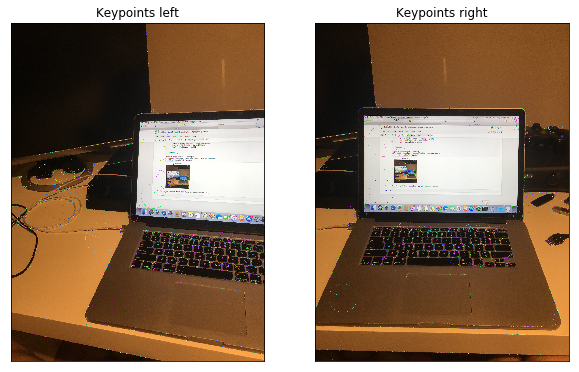

In [11]:
# load images
img1 = cv2.imread("img/left.jpg")
img2 = cv2.imread("img/right.jpg")

# convert to rgb
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# create copy
img1_kp = img1.copy()
img2_kp = img2.copy()

# create copy
img1_ransac = img1.copy()
img2_ransac = img2.copy()


sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

cv2.drawKeypoints(img1, kp1, img1_kp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img2, kp2, img2_kp,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img1_kp)
plt.title("Keypoints left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2_kp)
plt.title("Keypoints right"), plt.xticks([]), plt.yticks([])
plt.show()

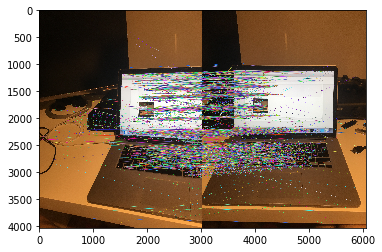

(<matplotlib.image.AxesImage at 0x112042a58>, None)

In [12]:
bf = cv2.BFMatcher()
raw_matches = bf.knnMatch(des1, des2, 2)

# Lowe ratio test
ratio = 0.75
matches = [m for m, n in raw_matches if m.distance < n.distance * ratio]

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
plt.imshow(img3), plt.show()

Number of inliers: 1495


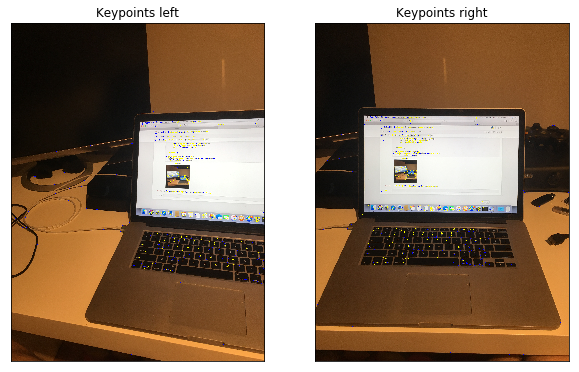

In [13]:
# From the documentation:
'''
If srcPoints and dstPoints are measured in pixels, it usually makes sense to set
this parameter somewhere in the range of 1 to 10.
'''
ransacReprojThreshold = 10.0


MIN_MATCH_COUNT = 4

if len(matches) > MIN_MATCH_COUNT:
    srcPoints = np.float32(
        [kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dstPoints = np.float32(
        [kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(
        srcPoints, dstPoints, cv2.RANSAC, ransacReprojThreshold)
    matchesMask = mask.ravel().tolist()
    print("Number of inliers: {}".format(matchesMask.count(1)))
    for i, (srcPt, dstPt, s) in enumerate(zip(srcPoints, dstPoints, matchesMask)):
        if s == 1:
            cv2.circle(img1_ransac, tuple(srcPt[0]), 3, (255, 255, 0), -1)
            cv2.circle(img2_ransac, tuple(dstPt[0]), 3, (255, 255, 0), -1)
        if s == 0:
            cv2.circle(img1_ransac, tuple(srcPt[0]), 3, (0, 0, 255), -1)
            cv2.circle(img2_ransac, tuple(dstPt[0]), 3, (0, 0, 255), -1)

else:
    print("Not enough matches are found - %d/%d" %
          (len(good), MIN_MATCH_COUNT))

# display images
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img1_ransac)
plt.title("Keypoints left"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2_ransac)
plt.title("Keypoints right"), plt.xticks([]), plt.yticks([])
plt.show()

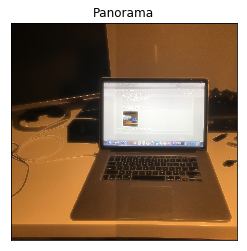

True

In [17]:
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

# perspective transform image 1
pts1_t = cv2.perspectiveTransform(pts1, H)

# connect the transformed image 1 points with original image 2 points
pts = np.concatenate((pts1_t, pts2), axis=0)

# get min and max coordinates of connected image
[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]

# make translation matrix to fit image 1 to connected result
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
Mt = np.float32([[1, 0, t[0]], [0, 1, t[1]]])

# warp perspective with original perspective matrix and translation matrix together
# set result size to calculated max size
result1 = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))

# warp affine with translation matrix on image 2
result2 = cv2.warpAffine(img2, Mt, (xmax-xmin, ymax-ymin))

final = blend(result1, result2)[400: -365, 275:]
plt.title("Panorama"), plt.xticks([]), plt.yticks([])
plt.imshow(final), plt.show()
cv2.imwrite("output/panorama.png", cv2.cvtColor(final, cv2.COLOR_BGR2RGB))